In [6]:
#@title setup libraries
import torch
import numpy as np
from PIL import Image
import os
import random
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
import subprocess
InteractiveShell.ast_node_interactivity = "all"
import glob

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
%cd /content/
!git clone https://github.com/openai/CLIP.git
%cd /content/CLIP/
!pip install ftfy
import clip
perceptor, preprocess = clip.load('ViT-B/32')

CUDA version: 11.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html
/content
fatal: destination path 'CLIP' already exists and is not an empty directory.
/content/CLIP


In [15]:
# create categories

# load imagenet categories
load_categories = "words in the communist manifesto" #@param ["imagenet", "dog vs cat", "pokemon", "words in the communist manifesto", "other (open this cell and write them into a list of strings)"]
if(load_categories=="imagenet"):
    !wget https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt -q
    import pandas as pd
    categories = pd.read_csv("map_clsloc.txt", sep=" ", header = None)[2]
    for category in range(len(categories)):
        categories[category] = categories[category].replace("_", " ")
elif(load_categories=="dog vs cat"):
    categories = ["dog", "cat"]
elif(load_categories=="pokemon"):
    !wget https://gist.githubusercontent.com/kingchloexx/339d43fe9ce0c77634fedacd2a8c1e14/raw/9fc5c32ef1619df4a32ff79b1d986c3e7d559634/pokemon.txt -q
    import pandas as pd
    categories = pd.read_csv("pokemon.txt", sep=".", header=None)[1]
elif(load_categories=="words in the communist manifesto"):
    !wget http://www.gutenberg.org/cache/epub/61/pg61.txt -O communism.txt -q
    ccc = open("communism.txt", "r").read().split()
    categories = []
    for i in ccc:
        if i not in categories:
            categories.append(i)
# encode categories with clip
c_encs = [perceptor.encode_text(clip.tokenize(category).cuda()).detach().clone() for category in categories]

##############################
Category:  object
##############################


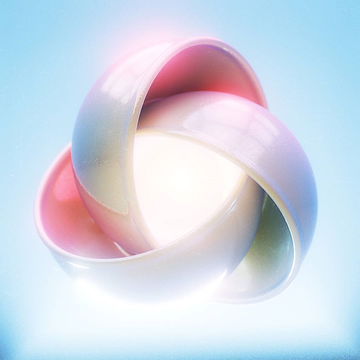

In [22]:
#@title classify
import PIL
# encode image and classify
file_url = "https://blobcdn.same.energy/b/f3/f1/f3f13a482a241d15b0571b9b4281f20c5d5f3755"#@param {type:"string"}
!wget "$file_url" -O /content/input.jpg -q
filename = "/content/input.jpg"
im_enc = perceptor.encode_image(preprocess(Image.open(filename)).unsqueeze(0).to("cpu"))
distances = [torch.cosine_similarity(e, im_enc).item() for e in c_encs]
print("#"*30)
print("Category: ",categories[int(distances.index(max(distances)))])
print("#"*30)
# display.display(display.Image(filename))

# resize image to fit in console better
base_width = 360
image = Image.open(filename)
width_percent = (base_width / float(image.size[0]))
hsize = int((float(image.size[1]) * float(width_percent)))
image = image.resize((base_width, hsize), PIL.Image.ANTIALIAS)
# display.display(display.Image(image))
image